**Computational Social Science**

*Assignment 1*

Link to github: https://github.com/Dribo/02467_A_1

*Contribution statement*

All the exercises have been completed in cooperation, where we have worked to complete one assignment before moving on to the next.

**Part 1: Using web-scraping to gather data**
The following cells contain the code for solve part 1 of the exercise

In [132]:
# Imports
from bs4 import BeautifulSoup
import requests
import re

In [133]:
requests.packages.urllib3.util.ssl_.DEFAULT_CIPHERS += 'HIGH:!DH:!aNULL'
try:
    requests.packages.urllib3.contrib.pyopenssl.DEFAULT_SSL_CIPHER_LIST += 'HIGH:!DH:!aNULL'
except AttributeError:
    # no pyopenssl support used / needed / available
    pass

# Getting the web-page
link19oral = "https://2019.ic2s2.org/oral-presentations/"
link19post = "https://2019.ic2s2.org/posters/"
r = requests.get(link19oral, verify=False)
soup = BeautifulSoup(r.content)
div = soup.find("div", {"class":"col-md-8"})
ps = div.findAll('p')
relevant = ps[3:]

G:\anaconda3\envs\02467 - css\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '2019.ic2s2.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [134]:
# Creating regex for filtering out names on the web-page for oral presentations
# regex1 is for names that have an initial in the middle, regex2 is for all other names
regex1 = r" ([a-zA-ZÀ-ÿ]* ([A-Z]. )+[a-zA-ZÀ-ÿ]+[.,])"
regex2 = r" ([a-zA-ZÀ-ÿ]* [a-zA-ZÀ-ÿ]+[.,])"
names = []
names1 = []
# Here we loop through the relevant part of the web-page and use the RegEx to find all the names and add them to a list
for r in relevant:
    retrieved = re.findall(regex1, str(r), re.UNICODE)
    names += retrieved

# Remove trailing spaces/dots
for i in range(len(names)):
    names[i] = names[i][0][:-1]

# This is the same but for regex2
for r in relevant:
    retrieved = re.findall(regex2, str(r), re.UNICODE)
    names1 += retrieved

for i in range(len(names1)):
    names1[i] = names1[i][:-1]

names += names1
list_of_presenters = names

In [135]:
# Getting the web-page for the posters
r = requests.get(link19post, verify=False)
soup = BeautifulSoup(r.content)
uls = soup.findAll('ul')
r1 = list(uls)[6]
r2 = list(uls)[7]

relevant1 = []
relevant2 = []

# Splitting the strings at new-lines
for x in list(r1):
    if x != '\n':
        relevant1.append(x)
for x in list(r2):
    if x != '\n':
        relevant2.append(x)

G:\anaconda3\envs\02467 - css\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host '2019.ic2s2.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [136]:
# Regex for filtering of posters
regex1 = r"<li>[a-zA-Z ]*<span>"
names = []
names1 = []
names2 = []
names3 = []
# The same as before where we use the regex to filter the strings and find the names
for r in relevant1:
    retrieved = re.findall(regex1, str(r), re.UNICODE)
    names += retrieved

for i in range(len(names)):
    names[i] = names[i][4:-6]
    names[i] = names[i].split(' and ')
    for j in range(len(names[i])):
        names1 += [names[i].pop(0)]

for r in relevant2:
    retrieved = re.findall(regex1, str(r), re.UNICODE)
    names2 += retrieved

for i in range(len(names2)):
    names2[i] = names2[i][4:-6]
    names2[i] = names2[i].split(' and ')
    for j in range(len(names2[i])):
        names3 += [names2[i].pop(0)]

list_of_presenters += names1 + names3
# Create the list of presenters and turn it into a set to remove dublicates
print('List of presenters with dublicates:', len(list_of_presenters))
print('List of presenters without dublicates :',  len(set(list_of_presenters)))

List of presenters with dublicates: 742
List of presenters without dublicates : 613


*Part 1*

    2. We got 613 unique authors in 2019 for both posters and oral presentations

    3. One decision that was taken during the web-scraping was to use RegEx to filter the out everything but the names. What this did was result in some oddities, where some elements got included that weren't names, and some names were cut off a bit too early, especially if they contained an intial as a middle name.

**Part 2: Getting Data from the Semantic Scholar API**
**2.1**
The starting point of the exercise will be the AuthorID.csv dataset, which contains Author names and IDs for all years. Some Authors did not show up in search, whom we will omit in the exercise.

Collaborators not included, first search result for each author name used to retrieve Author ID.

**2.2**
The exact code is all the following

In [137]:
# Imports
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from time import sleep

**Number of authors is printed here**

In [138]:
"""
        Read Dataset, remove rows with no Author ID
"""
NO_SEARCH_RESULT_ID = "No Search Result"

df_authorID = pd.read_csv('data/AuthorID.csv')
len_before = len(df_authorID)

df_authorID = df_authorID.fillna(NO_SEARCH_RESULT_ID)
df_authorID = df_authorID.loc[df_authorID['ID'] != NO_SEARCH_RESULT_ID]
len_after = len(df_authorID)

print(f"{len_after} total unique authors with Author ID, after omitting {len_before-len_after} due to unsuccessful search")


2743 total unique authors with Author ID, after omitting 270 due to unsuccessful search


In [139]:
"""
        Splits Author IDs into batches of size n
"""
AuthorIDs = list(df_authorID['ID'])

BATCH_SIZE = 100
Batch_AuthorIDs = []

# This chunks function is taken from a page on stackoverflow
def chunks(lst, n):
    """Helper function to split array into batches"""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

Batch_AuthorIDs = list(chunks(AuthorIDs, BATCH_SIZE))
print(f"Generated {len(Batch_AuthorIDs)} batches of size {BATCH_SIZE}")

"""
        Gets data and creates a list of each output from the API calls
"""
def get_data_from_authorIds(author_id_batch, max_attempts=3, delay_seconds=0):
    if max_attempts == 0:
        print("Error: A batch reached max attempts and will not be used later")
        return []

    BASE_URL = "https://api.semanticscholar.org/"
    VERSION = "graph/v1/"
    RESOURCE = "author/batch"

    complete_url = BASE_URL+VERSION+RESOURCE

    data = {"ids":list(author_id_batch)}
    params = {"fields":"name,aliases,citationCount,papers,papers.title,papers.abstract,papers.year,papers.s2FieldsOfStudy,papers.fieldsOfStudy,papers.citationCount,papers.externalIds,papers.authors"}

    response = requests.post(complete_url, json=data, params=params)
    response = response.json()

    if len(response) <= 1:
        sleep(delay_seconds)
        return get_data_from_authorIds(author_id_batch=author_id_batch, max_attempts=max_attempts-1, delay_seconds=delay_seconds)

    return response

list_response_data = [get_data_from_authorIds(batch, max_attempts=3, delay_seconds=0) for batch in tqdm(Batch_AuthorIDs)]


Generated 28 batches of size 100


 39%|███▉      | 11/28 [01:08<03:38, 12.86s/it]

Error: A batch reached max attempts and will not be used later


100%|██████████| 28/28 [02:20<00:00,  5.02s/it]


In [140]:
"""
        Compiles the list of JSON objects (dictionaries) into a list of DataFrames, then concatenated into a single DataFrame
"""
clean = [response_data for response_data in list_response_data if len(response_data) > 1]
print(len(clean), "out of", len(list_response_data), "searches were successful")

df_list_API_data = [pd.DataFrame.from_dict(response_data) for response_data in tqdm(clean)]
df_API_data = pd.concat(df_list_API_data, ignore_index=True)


27 out of 28 searches were successful


100%|██████████| 27/27 [00:00<00:00, 1804.86it/s]


In [141]:
"""
        Creates a new column 'fieldOfStudy' using a helper function, which returns field directly from the 'papers' data.
"""
def get_field_of_study(list_papers):
    if len(list_papers) == 0:
        return None
    try:
        dict_field_count = defaultdict(lambda: 0)
        for paper in list_papers:
            list_field = paper['fieldsOfStudy']
            if not list_field is None:
                for field in list_field:
                    dict_field_count[field] = dict_field_count[field] + 1

        return max(dict_field_count, key=dict_field_count.get)
    except KeyError: # When list_papers not a list but empty type
        return None
    except ValueError: # When dict is empty
        return None

df_API_data['fieldOfStudy'] = df_API_data.apply(lambda x: get_field_of_study(x['papers']), axis=1)


In [142]:
"""
        Finally, the Author Dataset is created by taking the required columns from API_data
"""
df_author_dataset = df_API_data[['authorId', 'name', 'aliases', 'citationCount', 'fieldOfStudy']].copy()


In [143]:
"""
        1. All paper data is taken from API_data, giving a list of JSON objects (dictionaries)
        2. Converted to list of DataFrame
        3. Concatenated
"""
list_paper_data = list(df_API_data['papers'])

df_list_Paper_data = [pd.DataFrame.from_dict(paper_data) for paper_data in list_paper_data]
df_Paper_data = pd.concat(df_list_Paper_data, ignore_index=True)


In [144]:
"""
        Extra columns required for papers are added into full Paper_data dataset.
        Then the dataset is split into Final_Paper, and Abstract datasets
"""
def get_DOI_Id(externalIds):
    try:
        return externalIds['DOI']
    except KeyError:
        return None

def get_Author_Ids(authors):
    IDs = []
    try:
        for author in authors:
            ID = author['authorId']
            if ID not in IDs:
                IDs += [ID]
        if len(IDs) == 0:
            return None
        return IDs
    except KeyError:
        return None

def get_fields_of_study(s2FieldsOfStudy):
    list_fields = []
    for dict_study in s2FieldsOfStudy:
        field = dict_study['category']
        if field not in list_fields:
            list_fields.append(field)
    return list_fields if list_fields else None

df_Paper_data['externalId.DOI'] = df_Paper_data.apply(lambda x: get_DOI_Id(x['externalIds']), axis=1)
df_Paper_data['authorIds'] = df_Paper_data.apply(lambda x: get_Author_Ids(x['authors']), axis=1)
df_Paper_data['fields'] = df_Paper_data.apply(lambda x: get_fields_of_study(x['s2FieldsOfStudy']), axis=1)

# Datasets 2 and 3 are created
df_Final_Paper_data = df_Paper_data[['paperId', 'title', 'year', 'externalId.DOI', 'citationCount', 'fields', 'authorIds']].copy()
df_Paper_Abstract_data = df_Paper_data[['paperId', 'abstract']].copy()

**2.3: Final lengths of DataFrames**

In [145]:
print("Final length of author data:",
      len(df_author_dataset),
      "Final length of paper data:",
      len(df_Final_Paper_data), sep='\n'
      )


Final length of author data:
2643
Final length of paper data:
96061


**Cells for looking at datasets**

In [146]:
df_author_dataset

,authorId,name,aliases,citationCount,fieldOfStudy
0,2081923667,Ding Jieyu,[Ding Jieyu],0,None
1,47632726,Qiusi Sun,None,85,Computer Science
2,47132201,Zhang Jingwen,"[Zhan Jingwen, Zhang Jingwen]",46,Materials Science
3,1818176,Mahmoudreza Babaei,[Mahmoud Babaei],537,Computer Science
4,2709512,Juhi Kulshrestha,None,718,Computer Science
...,...,...,...,...,...
2638,2074453526,Nak Won Rim,None,27,Medicine
2639,3130159,M. Berman,"[Marc Glenn Berman, M. G. Berman, Marc G Berma...",10296,Medicine
2640,4937157,Y. C. Leong,"[Y.c. Leong, Yuan Chang Leong]",1229,Psychology
2641,8912718,K. de la Haye,"[K De La Haye, K. De La Haye, Kayla De La Haye]",1406,Medicine


In [147]:
df_Final_Paper_data

,paperId,title,year,externalId.DOI,citationCount,fields,authorIds
0,64b569cd286d2d868370923146a309875b7b7f02,多刚体系统动力学方向矢量模型及多步块数值方法,2020,10.21656/1000-0887.400340,0,[Engineering],"[2138901195, 46269805, 2081923667]"
1,917f3f0a34a7dc9a7602ba8c78932bbb9b3e6a42,多体系统动力学微分-代数方程L-稳定方法,2019,10.21656/1000-0887.400038,0,[Physics],"[1573538979, 1491245320, 2081923667, 50587356]"
2,1e16ff1601d724962171031493830e0599fd228e,Who would respond to A troll? A social network...,2021,10.1016/J.CHB.2021.106786,5,"[Computer Science, Psychology]","[47632726, 39003910]"
3,288f55879cc77a1317aba73a51651405c7c69d24,Over-Time Trends in Incivility on Social Media...,2021,10.3389/fpos.2021.741605,3,[Sociology],"[47632726, 2496439, 102536922]"
4,a6d03cae8803bc9735f77765707a3fe570c3922e,How do we make the virtual world a better plac...,2021,10.1016/j.tele.2021.101747,6,"[Computer Science, Psychology]","[2056326856, 47632726, 30904401]"
...,...,...,...,...,...,...,...
96056,319279136b0d07909dc1a66ed853f624c518371c,The HMGB1 C-Terminal Tail Regulates DNA Bending.,2016,10.1016/j.jmb.2016.08.018,22,"[Medicine, Biology, Chemistry]","[33905657, 3937517, 13278004, 50260726, 245772..."
96057,669b985318857828b252664fb5027bf1ec3525a2,Single molecule microscopy reveals mechanistic...,2016,10.1093/nar/gkw321,17,"[Medicine, Biology]","[3937517, 5909882, 2457729]"
96058,babc51dd3a48cd077e86b3cce227cc3de541849a,Evaluating the Relationship between FRET Chang...,2016,10.1021/ACS.JCHEMED.5B00440,7,"[Chemistry, Biology]","[13278004, 3937517, 50260726, 5909882]"
96059,bfd319f19f29e78a36e6523a2f5e783179264626,Single molecule studies of RNA polymerase II t...,2014,None,0,"[Medicine, Biology]","[3937517, 2457729, 5909882]"


In [148]:
df_Paper_Abstract_data

,paperId,abstract
0,64b569cd286d2d868370923146a309875b7b7f02,None
1,917f3f0a34a7dc9a7602ba8c78932bbb9b3e6a42,None
2,1e16ff1601d724962171031493830e0599fd228e,None
3,288f55879cc77a1317aba73a51651405c7c69d24,Incivility in social media has become a major ...
4,a6d03cae8803bc9735f77765707a3fe570c3922e,None
...,...,...
96056,319279136b0d07909dc1a66ed853f624c518371c,None
96057,669b985318857828b252664fb5027bf1ec3525a2,Transcription by RNA polymerase II (Pol II) is...
96058,babc51dd3a48cd077e86b3cce227cc3de541849a,FRET (Forster resonance energy transfer) invol...
96059,bfd319f19f29e78a36e6523a2f5e783179264626,Eukaryotic mRNA transcription by RNA polymeras...


**Part 3: Law of large numbers**


In [149]:
# Import
import numpy as np
import matplotlib.pyplot as plt

In [150]:
# Solution to part 3.1
N = 10_000
X = np.random.normal(loc=0, scale=4, size=N)

In [151]:
# helper function
def pdf(x):
    mean = np.mean(x)
    std = np.std(x)
    y_out = 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std**2))
    return y_out

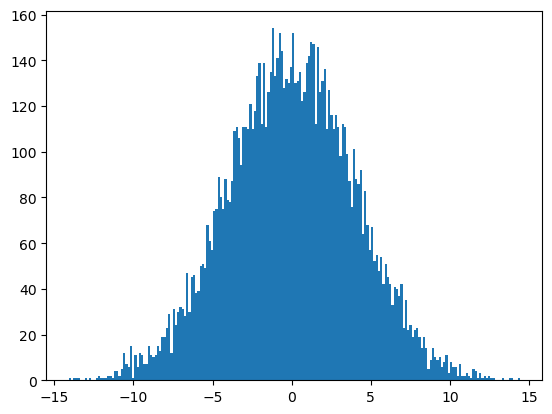

In [152]:
# Plotting the figure for 3.2
plt.hist(X, bins=200)
plt.show()

In [153]:
# Cumulative average for 3.3 and cumulative standard error for 3.4
cum_avg = np.zeros(N)
cum_std_err = np.zeros(N)
for i in range(N):
    cum_avg[i] = np.mean(X[:i+1])
    cum_std_err[i] = np.std(X[:i+1])/np.sqrt(i+1)
# Values of mean and median
mean = np.sum(X)/N
median = (sorted(X)[4999] + sorted(X)[5000])/2
print('Solution to 3.5')
print(f'Mean {mean}\nMedian {median}')

Solution to 3.5
Mean -0.014616535722681252
Median -0.010821016573255567


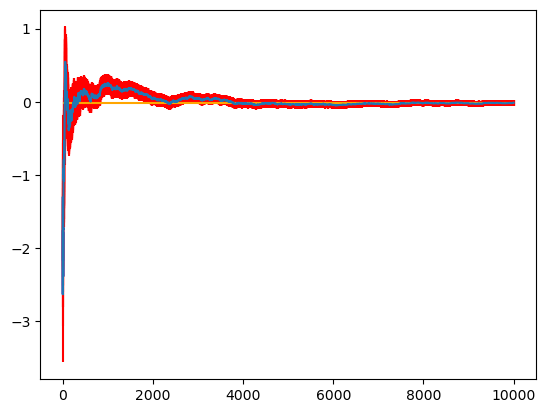

In [154]:
# Plotting for 3.6
plt.plot(range(1, N+1), cum_avg, 'b')
plt.errorbar(x=range(1, N+1), y=cum_avg, yerr=cum_std_err, ecolor='red')
plt.hlines(mean, xmin=0, xmax=N, colors='orange')
plt.show()

From this plot it can be seen that at first the mean varies quite a lot, and the error bars are quite large, and then as more and more of the dataset is considered it starts to converge on the distribution mean

In [155]:
# Computing cumulative median
cum_median = np.zeros(N)
for i in range(N):
    cum_median[i] = np.median(X[:i+1])

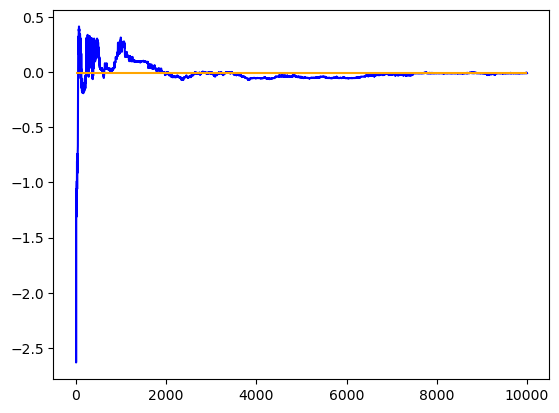

In [156]:
# Plotting for 3.8
plt.plot(range(1, N + 1), cum_median, 'b')
plt.hlines(median, xmin=0, xmax=N, colors='orange')
plt.show()

From the above plot it can be seen that, as with the mean, the median varies a lot in the beginning before converging on the distribution median

In [157]:
# Solution to 3.9
N = 10_000
X = np.random.pareto(a=0.5, size=N)

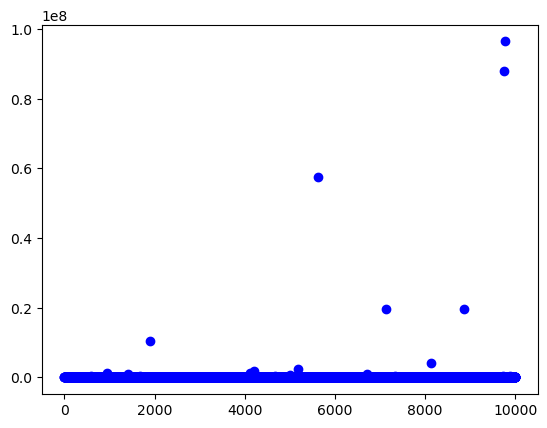

In [158]:
plt.plot(X, 'bo')
plt.show()

From this plot, the distribution of the data in the pareto distribution can be seen. Most of them are very low, with a few outliers.

In [159]:
# Cumulative average and median for perato
cum_avg = np.zeros(N)
cum_std_err = np.zeros(N)
cum_median = np.zeros(N)
for i in range(N):
    cum_avg[i] = np.mean(X[:i+1])
    cum_median[i] = np.median(X[:i+1])
    cum_std_err[i] = np.std(X[:i+1])/np.sqrt(i+1)
# Values of mean and median
mean = np.sum(X)/N
median = (sorted(X)[4999] + sorted(X)[5000])/2
print(f'Mean {mean}\nMedian {median}')

Mean 31251.32807066259
Median 3.0749901420726395


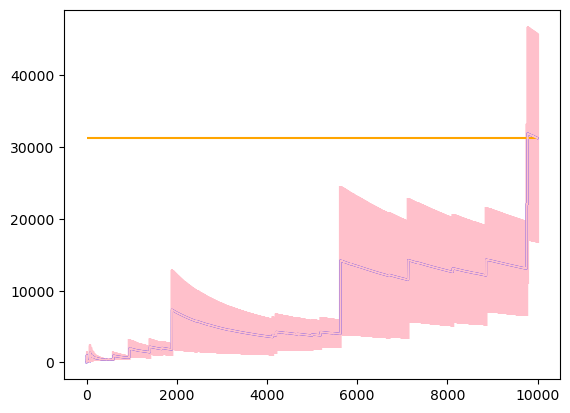

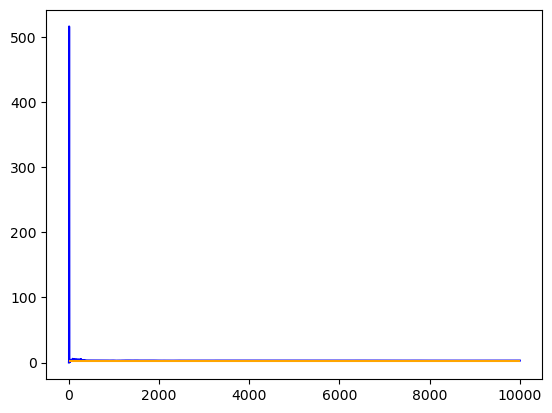

In [160]:
plt.errorbar(x=range(1, N+1), y=cum_avg, yerr=cum_std_err, color='pink')
plt.plot(range(1, N+1), cum_avg, 'blue')
plt.hlines(mean, xmin=0, xmax=N, colors='orange')
plt.show()
plt.plot(range(1, N + 1), cum_median, 'b')
plt.hlines(median, xmin=0, xmax=N, colors='orange')
plt.show()

These plots show the cumulative mean and median for the pareto distribution. From the first one we see the mean has large error bars, even though it converges.

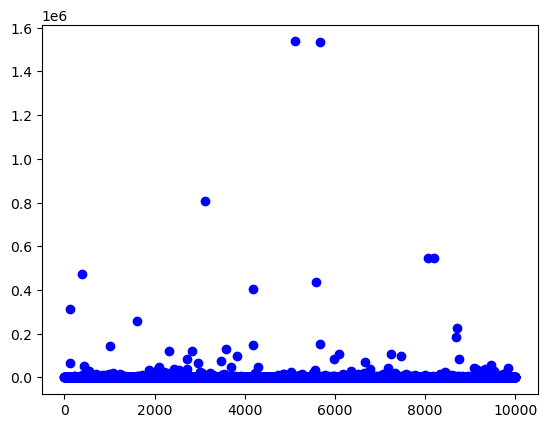

In [161]:
X = np.random.lognormal(0, 4, N)
plt.plot(X, 'bo')
plt.show()

This plot shows the distribution of the data from the log normal distribution

In [162]:
# Cumulative average and median for lognormal
cum_avg = np.zeros(N)
cum_std_err = np.zeros(N)
cum_median = np.zeros(N)
for i in range(N):
    cum_avg[i] = np.mean(X[:i+1])
    cum_median[i] = np.median(X[:i+1])
    cum_std_err[i] = np.std(X[:i+1])/np.sqrt(i+1)
# Values of mean and median
mean = np.sum(X)/N
median = (sorted(X)[4999] + sorted(X)[5000])/2
print(f'Mean {mean}\nMedian {median}')

Mean 1219.115807389948
Median 1.0029051310774446


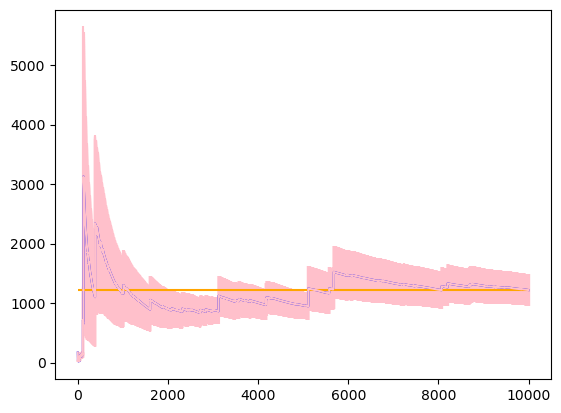

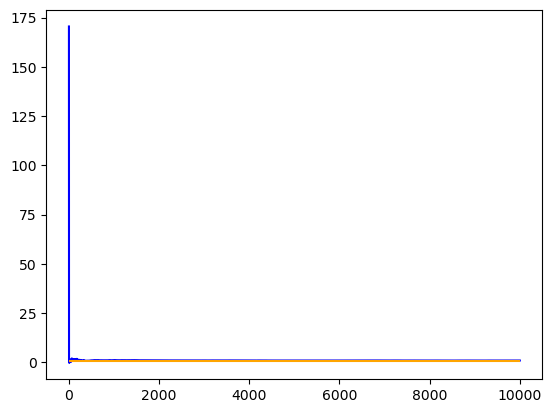

In [163]:
plt.errorbar(x=range(1, N+1), y=cum_avg, yerr=cum_std_err, color='pink')
plt.plot(range(1, N+1), cum_avg, 'blue')
plt.hlines(mean, xmin=0, xmax=N, colors='orange')
plt.show()
plt.plot(range(1, N + 1), cum_median, 'b')
plt.hlines(median, xmin=0, xmax=N, colors='orange')
plt.show()

These plots show exactly the same situation as before, with larger error bars for mean than the regular normal distribution

In [169]:
# Solution to 3.13
pop = np.array(df_Final_Paper_data['citationCount'])
print(f'Mean of citation counts : {np.mean(pop)}\nMedian of citation counts : {np.median(pop)}')
X = np.random.choice(pop, N)

Mean of citation counts : 39.012231811036735
Median of citation counts : 4.0


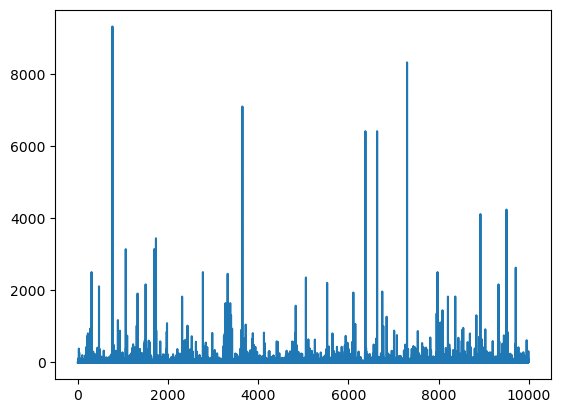

In [177]:
plt.plot(X)
plt.show()

This plot shows the distribution of the data in the citations dataset

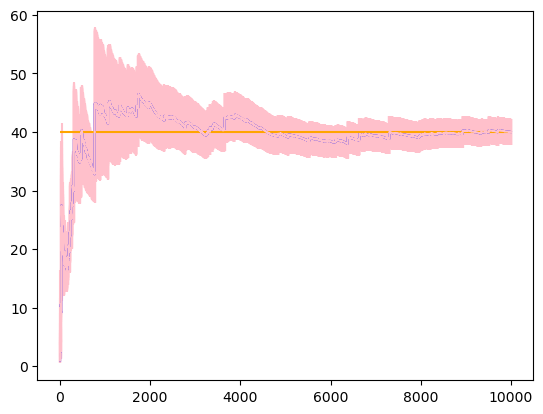

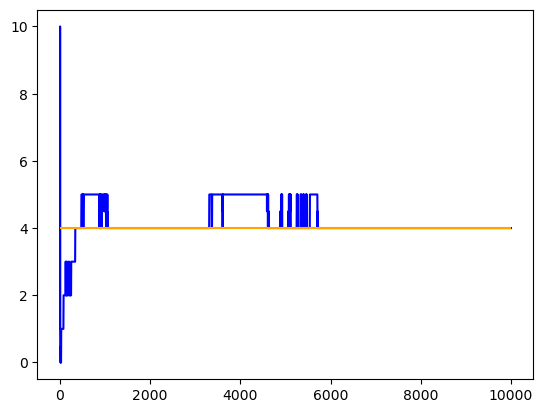

In [180]:
# Cumulative average and median for citations
cum_avg = np.zeros(N)
cum_std_err = np.zeros(N)
cum_median = np.zeros(N)
for i in range(N):
    cum_avg[i] = np.mean(X[:i+1])
    cum_median[i] = np.median(X[:i+1])
    cum_std_err[i] = np.std(X[:i+1])/np.sqrt(i+1)
plt.errorbar(x=range(1, N+1), y=cum_avg, yerr=cum_std_err, color='pink')
plt.plot(range(1, N+1), cum_avg, 'blue')
plt.hlines(mean, xmin=0, xmax=N, colors='orange')
plt.show()
plt.plot(range(1, N + 1), cum_median, 'b')
plt.hlines(median, xmin=0, xmax=N, colors='orange')
plt.show()

Here we see the plots of the cumulative average and mean for the citations data, which shows to be quite similar to either the LogNormal or the pareto with larger error bars and greater variance

* Compare the evolution of the cumulative average for the Gaussian, Pareto and LogNormal distribution. What do you observe? Would you expect these results? Why?
    We observe that the cumulative average varies quite a bit in the beginning, and then converges exactly as expected. We also see that the error bars are larger for both the pareto and the LogNormal, indicating that we are less sure about that compared to the gaussian. We expect the convergence due to the law of large numbers.
* Compare the cumulative median vs the cumulative average for the three distributions. What do you observe? Can you draw any conclusions regarding which statistics (the mean or the median) is more usfeul in the different cases?
    In case of the Gaussian the mean and the median are very close to each other, and both can be used. For the two others, there are outliers that pull a lot on the mean, meaning that it is not a very good statistic to understand the data, and the median should be used instead.
* Consider the plots you made using the citation count data in point 14. What do you observe? What are the implications?
    We observe something quite similar to the parato distribution or the log normal distribution. This implies that the citations data is drawn from one of these distributions, which implies that this data also follows the 80-20 rule.
* What do you think are the main take-home message of this exercise?
    One of the main messages, we think, is that a lot of the volume in this kind of data is found in the first few observations, and that it closely follows the 80-20 rule, just like the parato distribution.
